## EXERCISE 0

Download and extract the Python version of the CIFAR dataset from the CIFAR website.  
The dataset is structured as follows:

- **5 training batches** of 10,000 images each (50,000 images total)  
- **1 test batch** of 10,000 images  

Each batch file contains a **dictionary** with the following elements:

- **`data`** – a 10,000 × 3,072 NumPy array of `uint8`.  
  Each row represents a 32×32 color image:  
  - The first 1,024 entries are the red channel,  
  - The next 1,024 entries are the green channel,  
  - The final 1,024 entries are the blue channel.  
  Images are stored in **row-major order**, i.e., the first 32 entries correspond to the red values of the first row of the image.

- **`labels`** – a list of 10,000 integers in the range 0–9.  
  The number at index `i` indicates the label of the `i`th image in `data`.

The dataset also contains another file called **`batches.meta`**, which is a Python dictionary with the following entry:

- **`label_names`** – a 10-element list giving meaningful names to the numeric labels in the `labels` array described above.  
  For example:  
  ```python
  label_names[0] == "airplane"
  label_names[1] == "automobile"
  # etc.


Number of training samples: 50000
Image shape: torch.Size([3, 32, 32]) Label: 6


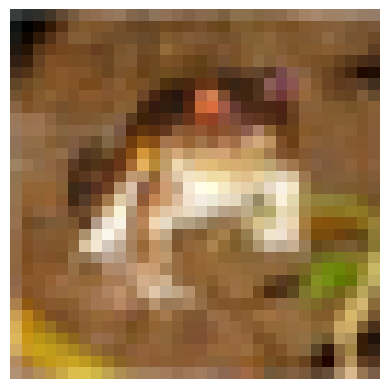

Label: 6


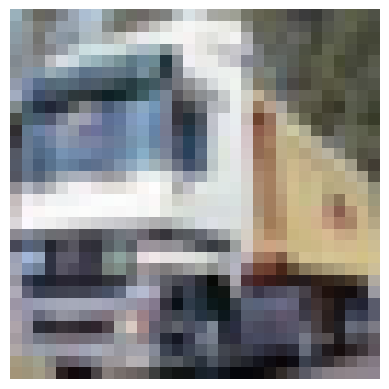

Label: 9


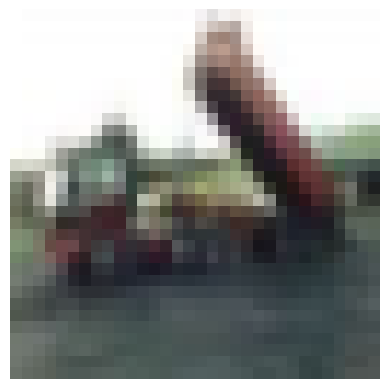

Label: 9


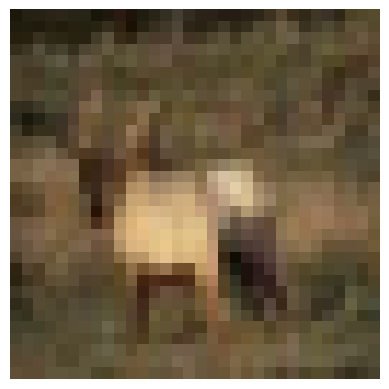

Label: 4


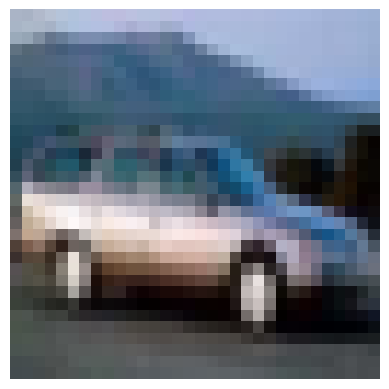

Label: 1


In [13]:
import pickle
import numpy as np
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

class CIFAR10Dataset(Dataset):
    def __init__(self, path, data_type='train', transform=None):
        """
        Args:
            path (str): path to the CIFAR-10 data files
            data_type (str): 'train' or 'test'
            transform (callable, optional): transformation to apply to each image
        """
        self.path = path
        self.transform = transform
        self.data = []
        self.labels = []

        if data_type == 'train':
            # load all 5 training batches
            for i in range(1, 6):
                file = f"{path}/data_batch_{i}"
                with open(file, 'rb') as fo:
                    batch = pickle.load(fo, encoding='bytes')
                    # reshape to (10000,3,32,32)
                    imgs = np.reshape(batch[b'data'], (10000, 3, 32, 32))
                    self.data.append(imgs)
                    self.labels += batch[b'labels']
            self.data = np.vstack(self.data)  # shape (50000,3,32,32)
        elif data_type == 'test':
            file = f"{path}/test_batch"
            with open(file, 'rb') as fo:
                batch = pickle.load(fo, encoding='bytes')
                self.data = np.reshape(batch[b'data'], (10000, 3, 32, 32))
                self.labels = batch[b'labels']

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]  # CHW
        label = self.labels[idx]

        # Convert CHW -> HWC for ToTensor
        img = np.transpose(img, (1, 2, 0))

        # Apply transformation if provided
        if self.transform:
            img = self.transform(img)

        return img, label

    def visualize(self, img):
        """Visualize a single image (tensor or NumPy array)."""
        if isinstance(img, torch.Tensor):
            img = img.clone().detach()
            img = img.numpy()
            img = np.transpose(img, (1, 2, 0))  # CHW -> HWC
            img = img * 0.5 + 0.5  # denormalize
        elif img.max() > 1.0:
            img = img / 255.0  # normalize if uint8

        plt.imshow(img)
        plt.axis('off')
        plt.show()


# ------------------------------
# Main: Instantiate and test
# ------------------------------

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # converts HWC uint8 image to CHW float tensor [0,1]
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))  # normalize to [-1,1]
])

# Load the dataset
dataset = CIFAR10Dataset(path='data', data_type='train', transform=transform)

# Check dataset size
print("Number of training samples:", len(dataset))

# Get one sample
img, label = dataset[0]
print("Image shape:", img.shape, "Label:", label)

# Visualize first 5 images
for i in range(5):
    img, label = dataset[i]
    dataset.visualize(img)
    print("Label:", label)


## **EXERCISE 2** 
Build a CNN model to predict a class from the input image (you can use
the Conv2D module and one of the plenty pooling layers already implemented).

Which are the main hyperparameters you should set to build the main model?

Good practice is to build the model class as general as possible, and specify the
hyperparaemeters when the class is called.

#### **Explanation**

In the follwing code there is implemented a general convolutional neural network (CNN) that mimics the standard CNN pipeline studied in class:

Convolution → Activation → Pooling → Flatten → Fully connected → Output.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class GeneralCNN(nn.Module):
    
    ## 1. Building my constructor
    # Input parameters (the hyperparameters) - arguments that control every important aspect of the CNN architecture
    def __init__(self, 
                 in_channels=3, 
                 num_classes=10, 
                 conv_layers=[(6, 5), (16, 5)], 
                 pool_type='max',
                 pool_kernel=2,
                 pool_stride=2,
                 fc_layers=[120, 84]):
        """
        A general CNN model structure for image classification tasks.

        Args:
            in_channels (int): number of input channels (3 for RGB images)
            num_classes (int): number of output classes
            conv_layers (list of tuples): (out_channels, kernel_size) for each conv layer, describing each convolutional layer: how many filters and what kernel size
            pool_type (str): type of pooling ('max' or 'avg')
            pool_kernel (int): kernel size for pooling
            pool_stride (int): stride for pooling
            fc_layers (list): list with number of neurons in each fully connected layer
        """
        super(GeneralCNN, self).__init__()

        self.layers = nn.ModuleList() #list that will hold the convolutional layers built, each filter (or kernel) slides over the image, computing feature maps
        current_channels = in_channels

        ### Building each convolutional layer
        for out_channels, kernel_size in conv_layers: #creates as many convolutional layers as specified in conv_layers
            conv = nn.Conv2d(current_channels, out_channels, kernel_size=kernel_size) #From the guidelines - Each Conv2d applies a 2D convolution operation: each filter (or kernel) slides over the image, computing feature maps
            self.layers.append(conv)
            current_channels = out_channels

        ### Pooling - Pooling reduces the spatial resolution and helps the model focus on what patterns are present, not where they are. This is key for making CNNs translation-invariant
        if pool_type == 'max':
            self.pool = nn.MaxPool2d(kernel_size=pool_kernel, stride=pool_stride)
        elif pool_type == 'avg':
            self.pool = nn.AvgPool2d(kernel_size=pool_kernel, stride=pool_stride)
        else:
            raise ValueError("pool_type must be 'max' or 'avg'")

        ### Fully connected layers (classifier)
        self.fc_layers = nn.ModuleList() # Empty for now
        self.fc_config = fc_layers # Store the configuration of the fully connected layers
        self.num_classes = num_classes # Number of output classes
        
        # initialize fully connected layers later (after we know input size)
    
    # After __init__, the model knows its structure, but it doesn’t yet know how many inputs will go into the fully connected part — because the flatten size depends on the image size and convolution parameters.




    ## This defines the fully connected layers, because their input size depends on the output size of the convolution+pooling part.
    def build_fc_layers(self, flattened_size): #method that creates the layers dynamically the first time the model runs
        """Define fully connected layers once flattened size is known."""
        layers = []
        input_size = flattened_size
        for units in self.fc_config:
            layers.append(nn.Linear(input_size, units))
            input_size = units
        layers.append(nn.Linear(input_size, self.num_classes))
        self.fc_layers = nn.ModuleList(layers)
        print(f"Building FC layers with input size {flattened_size}")




    ## Called every time you call the model with data (model(x)):
    # Applies the operations defined in __init__ (and those added in build_fc_layers) to the input data — in the correct sequence.
    def forward(self, x):
        print("Starting forward pass...")
        # Apply convolutional layers - The input tensor (x) goes through every convolutional layer defined in __init__
        for conv in self.layers: 
            print(f"Input to conv: {x.shape}")
            x = F.relu(conv(x)) #Convolution + ReLU activation (applied after each convolution)
            # ReLU -> Every negative value in the output volume from the convolution layer is replaced with zero. This is done to prevent the values from summing up to zero.
            x = self.pool(x)  # +Pooling (after each conv)
            print(f"After pooling: {x.shape}")
        
        # Flatten - This converts the 3D feature map into a 1D vector (so it can go into linear layers)
        x = torch.flatten(x, 1)
        print(f"After flatten: {x.shape}")

        # If FC layers not yet built (first forward), build them dynamically
        if not self.fc_layers:
            print("FC layers not built yet — building them now!")
            self.build_fc_layers(x.shape[1]) # This calls build_fc_layers() once

        # Pass through fully connected layers
        for i, fc in enumerate(self.fc_layers):
            print(f"Passing through FC layer {i+1}")
            if i < len(self.fc_layers) - 1:  # all but last layer
                x = F.relu(fc(x)) # activation for all but last layer
            else:
                x = fc(x) ## last layer = output layer (no activation)
        print("Forward pass done.")
        return x #The final x is returned — this is THE output (the predictions)


Dummy example

In [21]:
model = GeneralCNN()
dummy = torch.randn(1,3,32,32)
output = model(dummy)


Starting forward pass...
Input to conv: torch.Size([1, 3, 32, 32])
After pooling: torch.Size([1, 6, 14, 14])
Input to conv: torch.Size([1, 6, 14, 14])
After pooling: torch.Size([1, 16, 5, 5])
After flatten: torch.Size([1, 400])
FC layers not built yet — building them now!
Building FC layers with input size 400
Passing through FC layer 1
Passing through FC layer 2
Passing through FC layer 3
Forward pass done.


### **Which main hyperparameters must we set?**

1. **Convolutional hyperparameters:**

- conv1_channels, conv2_channels — number of filters in each conv layer (controls model capacity / feature depth). Lecture: depth equals number of filters. 

- kernel_size — the size of each filter (e.g., 5 means 5×5). Larger kernel → bigger receptive field (detects larger patterns). 

- padding and stride — used to control output size and sampling.

2. **Pooling hyperparameters**

- pool_type — 'avg' or 'max' (lecture explains both). Max is common for feature preservation; average sometimes used where smoothing is desirable. 

- pool_kernel & pool_stride — window size and stride for downsampling (lecture: pooling has these hyperparameters). 

3. **Fully connected hyperparameters**

- fc_spatial (Approach A) or fc1_units, fc2_units — number of neurons in FC layers (controls classifier capacity). The lecture mentions designing FC layers after flattening. 

4. **Other general choices**

- num_classes — target number of classes (here CIFAR-10 → 10).

- Activation choice — ReLU is standard and recommended in lecture. 

These are all exposed as __init__ arguments in the model classes above, so I can instantiate many variants without changing the class body.

In [18]:
# Instantiate your general CNN (no specific hyperparameters yet)
model = GeneralCNN()

# Print architecture
print(model)


GeneralCNN(
  (layers): ModuleList(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_layers): ModuleList()
)


In [19]:
def debug_forward(model, x):
    print("Input shape:", x.shape)
    for i, conv in enumerate(model.layers):
        x = F.relu(conv(x))
        print(f"After Conv layer {i+1}: {x.shape}")
        x = model.pool(x)
        print(f"After Pool layer {i+1}: {x.shape}")
    x = torch.flatten(x, 1)
    print("After Flatten:", x.shape)
    if not model.fc_layers:
        model.build_fc_layers(x.shape[1])
        print("Fully connected layers built with input size:", x.shape[1])
    for i, fc in enumerate(model.fc_layers):
        x = fc(x)
        print(f"After FC layer {i+1}: {x.shape}")
        if i < len(model.fc_layers) - 1:
            x = F.relu(x)
    return x


In [22]:
dummy_input = torch.randn(1, 3, 32, 32)  # batch of 1 image, 3 channels, 32x32
output = debug_forward(model, dummy_input)
print("Final output shape:", output.shape)


Input shape: torch.Size([1, 3, 32, 32])
After Conv layer 1: torch.Size([1, 6, 28, 28])
After Pool layer 1: torch.Size([1, 6, 14, 14])
After Conv layer 2: torch.Size([1, 16, 10, 10])
After Pool layer 2: torch.Size([1, 16, 5, 5])
After Flatten: torch.Size([1, 400])
After FC layer 1: torch.Size([1, 120])
After FC layer 2: torch.Size([1, 84])
After FC layer 3: torch.Size([1, 10])
Final output shape: torch.Size([1, 10])


In [23]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")


Total trainable parameters: 62006


#### **Exercise E2 – Building a General CNN Explanation**

This model defines a <strong>flexible CNN architecture</strong> that can later be configured with
specific hyperparameters (for Exercise E3). It follows exactly the theory from the Convolutional Neural Network lecture.</p>

#### **Main components:**

- <strong>Convolution layers</strong>: learn feature detectors that extract edges, textures, and shapes.
- <strong>Activation (ReLU)</strong>: introduces non-linearity, letting the model learn complex features.
- <strong>Pooling</strong>: reduces spatial size, making the network more robust to position changes.
- <strong>Flattening</strong>: converts 3D feature maps into a 1D vector.
- <strong>Fully Connected layers</strong>: perform the classification using learned features.


#### **Main hyperparameters to specify:**

- Number of convolutional layers and filters
- Kernel size of each convolution
- Pooling type (max or average), kernel, and stride
- Number of neurons in fully connected layers
- Number of output classes

#### **Good practice:**
The model class is <strong>general</strong>: all hyperparameters can be set when the class is called,
and the fully connected layers are created automatically based on the input size. This ensures reusability and avoids hardcoding.</p>
